In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import h5py
import matplotlib.colors as mcolors

import sys
from scipy import stats
from pathlib import Path
import re

sys.path.append("../lib/")
import matplotlib.pyplot as plt
from figparams import *

plt.rcParams.update(rc_params)
from utils import *


In [7]:
colors_tot = get_colormap_colors(24, "plasma")
colors = colors_tot[:12][::-1]


In [8]:
year = 31555600
for i in range(24):
    # read yaml
    with open(
        f"../data/first_year_egf/pack_{i + 1}/injected_pack{i + 1}.yaml", "r"
    ) as file:
        injected = yaml.safe_load(file)

    a1 = injected["sources"]["galactic_DWD_time"][0]["injected"]
    ak = injected["sources"]["galactic_DWD_time"][1]["injected"]
    b1 = injected["sources"]["galactic_DWD_time"][2]["injected"]
    bk = injected["sources"]["galactic_DWD_time"][3]["injected"]
    amp = injected["sources"]["galactic_DWD_time"][5]["injected"]
    Tobs = injected["sources"]["galactic_DWD_time"][7]["injected"]
    Tobs /= year

    f1 = a1 * np.log10(Tobs) + b1
    fk = ak * np.log10(Tobs) + bk

    yaml_path = f"../data/first_year_egf/pack_{i + 1}/nessai/Gamma/cyclo/pe_pack{i + 1}_cyclo.yaml"
    with open(yaml_path, "r") as file:
        true = yaml.safe_load(file)

    for j in true["sources"]["galactic_DWD_time"]:
        if j["name"] == "fr1":
            j["injected"] = float(round(f1, 3))
        if j["name"] == "fknee":
            j["injected"] = float(round(fk, 3))
        if j["name"] == "amp":
            j["injected"] = amp

    yaml_path_c = f"../data/first_year_egf/pack_{i + 1}/nessai/Gamma/cyclo/pec_pack{i + 1}_cyclo.yaml"
    with open(yaml_path_c, "w") as newfile:
        yaml.dump(true, newfile, default_flow_style=False, allow_unicode=True)

    newfile.close()

In [ ]:
def load_posterior_data(
    n_packs=24,
    mode="your_mode_here",
    folder="../data/first_year_egf/",
    pack_indices=None,
):
    """
    Load posterior samples from HDF5 files and corresponding true values from YAML

    Parameters:
    -----------
    n_packs : int
        Number of packs to load
    mode : str
        Mode for the analysis

    Returns:
    --------
    all_samples : list
        List of posterior samples for each pack
    parameter_names : list
        Names of the parameters
    true_values : list
        True injected values for each pack
    """

    all_samples = []
    all_true_values = []
    parameter_names = None

    for p in pack_indices:
        pack_id = p + 1  # Adjust for 1-based indexing
        # Load posterior samples from HDF5
        hdf5_path = folder + f"pack_{pack_id}/nessai/Gamma/{mode}/result.hdf5"

        if not Path(hdf5_path).exists():
            print(f"Warning: {hdf5_path} not found, skipping pack_{pack_id}")
            continue

        try:
            with h5py.File(hdf5_path, "r") as f:
                posterior = f["posterior_samples"][:]
                # Get parameter names from dtype (first time only)
                if parameter_names is None:
                    dtype = posterior.dtype
                    parameter_names = list(dtype.names)

        except Exception as e:
            print(f"Error loading {hdf5_path}: {e}")
            continue

        # Load true values from YAML
        if mode == "noegf":
            yaml_path = (
                folder
                + f"pack_{pack_id}/nessai/Gamma/{mode}/pec_pack{pack_id}_cyclo.yaml"
            )
        else:
            yaml_path = (
                folder
                + f"pack_{pack_id}/nessai/Gamma/{mode}/pec_pack{pack_id}_{mode}.yaml"
            )
            print(yaml_path)

        if Path(yaml_path).exists():
            try:
                with open(yaml_path, "r") as file:
                    sources = yaml.safe_load(file)["sources"]
                    true_values = [
                        item["injected"]
                        for category in sources.values()
                        for item in category
                    ]
            except Exception as e:
                print(f"Error loading {yaml_path}: {e}")
                true_values = [0] * len(parameter_names)
        else:
            print(f"Warning: {yaml_path} not found, using zeros for true values")
            true_values = [0] * len(parameter_names) if parameter_names else []

        # Convert structured array to regular array
        if parameter_names and len(true_values) > 0:
            n_params = min(len(parameter_names), len(true_values))
            samples = np.vstack(
                [posterior[name] for name in parameter_names[:n_params]]
            ).T

            all_samples.append(samples)
            all_true_values.append(true_values[:n_params])

    return (
        all_samples,
        parameter_names[: len(true_values)] if parameter_names else [],
        all_true_values,
    )


In [32]:
label_plot = [
    r'$\Delta{\mathcal{A}_{\rm{EF}}}$', 
    r'$\Delta{\gamma_1}$', 
    r'$\Delta{\gamma_2}$',
    r"$\Delta{\alpha}$",
    r"$\Delta{\mathcal{A}}$",
    r"$\Delta{f_{\mathrm{knee}}}$",
    r"$\Delta{f_{1}}$",
    r"$\Delta{f_{2}}$",
    r"$\Delta{\sin \beta}$",
    r"$\Delta{\lambda}$",
    r"$\Delta{\sin \psi}$",
    r"$\Delta{\sigma_1^2}$",
    r"$\Delta{\sigma_2^2}$",
    r"$\Delta{\mathcal{P}_{\mathrm{tm}}}$",
    r"$\Delta{\mathcal{P}_{\mathrm{oms}}}$",
]


def add_overline(latex_str):
    """Wrap the main LaTeX expression in \Delta{}."""
    inner = latex_str.strip("$")  # Remove surrounding dollar signs
    return f"$\\Delta{{{inner}}}$"


def strip_delta(latex_str):
    """Remove \Delta from a LaTeX string if present."""
    return re.sub(r"\\Delta{(.*?)}", r"\1", latex_str)


def create_ridgeline_plot(
    data_dict, colors=None, figsize=None, spacing=0.8, alpha=0.7, linewidth=1.5
):
    """
    Create a ridgeline plot from a dictionary of data with proper size management.

    Parameters:
    -----------
    data_dict : dict
        Dictionary with labels as keys and data arrays as values
    colors : list or colormap
        Colors for each distribution
    figsize : tuple
        Figure size (width, height). If None, automatically calculated
    spacing : float
        Vertical spacing between distributions
    alpha : float
        Transparency of filled areas
    linewidth : float
        Width of distribution outlines
    """

    n_distributions = len(data_dict)

    # Automatically calculate figure size if not provided
    if figsize is None:
        # Limit height based on number of distributions
        max_height = 20  # Maximum height in inches
        width = min(12, max(8, n_distributions * 0.5))  # Reasonable width
        height = min(max_height, max(6, n_distributions * spacing + 2))
        figsize = (width, height)
    else:
        # Ensure figsize doesn't exceed reasonable limits
        width, height = figsize
        max_width, max_height = 15, 20
        if width > max_width or height > max_height:
            print(f"Warning: Reducing figsize from {figsize} to reasonable limits")
            width = min(width, max_width)
            height = min(height, max_height)
            figsize = (width, height)

    print(
        f"Creating ridgeline plot with {n_distributions} distributions, figsize: {figsize}"
    )

    fig, ax = plt.subplots(figsize=figsize)

    # Generate colors if not provided
    if colors is None:
        # Create a gradient from purple to orange
        colors = plt.cm.plasma(np.linspace(0.1, 0.9, n_distributions))

    # Calculate global data range for consistent x-axis
    all_data = np.concatenate(list(data_dict.values()))
    data_min, data_max = np.percentile(
        all_data, [1, 99]
    )  # Use percentiles to avoid outliers
    data_range = data_max - data_min
    x_min = data_min - 0.1 * data_range
    x_max = data_max + 0.1 * data_range

    # Plot each distribution
    for i, (label, data) in enumerate(data_dict.items()):
        if len(data) == 0:
            continue

        # Calculate kernel density estimation
        try:
            density = stats.gaussian_kde(data)
            x_range = np.linspace(x_min, x_max, 200)
            y_density = density(x_range)
        except (np.linalg.LinAlgError, ValueError) as e:
            print(
                f"Warning: Could not compute KDE for {label}, using histogram instead"
            )
            # Fallback to histogram
            hist, bin_edges = np.histogram(data, bins=50, density=True)
            x_range = (bin_edges[:-1] + bin_edges[1:]) / 2
            y_density = hist

        # Scale and shift the density curve
        if y_density.max() > 0:
            y_density = y_density / y_density.max() * 0.4  # Scale height
        # Add overlap: reduce spacing and shift slightly up to avoid full overwrite
        overlap_factor = 0.5  # controls how much one row overlaps the next (0 = full overlap, 1 = no overlap)
        adjusted_spacing = spacing * overlap_factor
        y_position = i * adjusted_spacing

        # Plot filled area
        ax.fill_between(
            x_range,
            y_position,
            y_position + y_density,
            alpha=alpha,
            color=colors[i],
            linewidth=0,
        )

        # Plot outline
        ax.plot(x_range, y_position + y_density, color="white", linewidth=linewidth)

        # Add label - adjust position based on data range
        label_x = x_min - 0.05 * data_range
        ax.text(
            label_x,
            y_position + 0.2,
            label,
            fontsize=18,
            verticalalignment="center",
            ha="right",
        )

    # Customize plot
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-0.5, n_distributions * spacing)
    ax.set_xlabel("Parameter Value", fontsize=18)
    # ticks = np.round(np.linspace(x_min, x_max, 8), 3)
    ticks = np.round(np.linspace(x_min, x_max, 5), 3)  # Fewer ticks
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, fontsize=14, rotation=45, ha="right")  # Smaller, rotated
    # ax.set_xticks(ticks)
    # ax.set_xticklabels(ticks, fontsize=18)
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    ax.grid(True, alpha=0.3, axis="x")

    plt.tight_layout()
    return fig, ax


def create_combined_ridgeline_plot(
    all_samples,
    parameter_names,
    figsize=None,
    overlap_factor=0.5,
    spacing=0.8,
    alpha=0.7,
    linewidth=1.5,
    center_on_true_values=False,
    all_true_values=None,
    selected_params=None,
    pack_indices=None,
    max_packs_per_plot=12,
):
    """
    Create a grid of ridgeline plots for a selected subset of parameters.

    Parameters:
    -----------
    all_samples : list of np.ndarray
        Posterior samples, one per pack
    parameter_names : list of str
        Names of the parameters
    figsize : tuple
        Optional figure size
    spacing : float
        Vertical spacing
    alpha : float
        Transparency
    linewidth : float
        Outline width
    center_on_true_values : bool
        Center samples on true injected values
    all_true_values : list of lists
        True values for each pack
    selected_params : list of str
        Subset of parameters to plot (can be names or LaTeX labels from label_plot)
    pack_indices : list of int
        Indices of packs to include
    max_packs_per_plot : int
        Maximum number of packs per plot

    Returns:
    --------
    fig, axs : matplotlib Figure and Axes array
    """

    # Determine which packs to include
    if pack_indices is not None:
        selected_pack = sorted(set(pack_indices))
    else:
        selected_pack = list(range(len(all_samples)))

    # Determine selected parameter indices
    if selected_params is not None:
        selected_indices = []
        for p in selected_params:
            if p in parameter_names:
                selected_indices.append(parameter_names.index(p))
            elif p in label_plot:
                selected_indices.append(label_plot.index(p))
            else:
                print(
                    f"Warning: Parameter '{p}' not found in parameter_names or label_plot, skipping."
                )

        if not selected_indices:
            print("No valid parameters selected. Skipping plot.")
            return None, None

        selected_parameter_names = [parameter_names[i] for i in selected_indices]
    else:
        selected_indices = list(range(len(parameter_names)))
        selected_parameter_names = parameter_names

    n_packs = len(selected_pack)
    n_params = len(selected_indices)

    pack_labels = [f"Packet {i + 1}" for i in selected_pack]

    # Prepare data
    data_grid = {}
    for pack_idx, samples in enumerate(all_samples):
        if pack_idx not in selected_pack:
            continue

        pack_label = f"Packet {pack_idx + 1}"
        for param_idx in selected_indices:
            if param_idx < samples.shape[1]:
                param_name = parameter_names[param_idx]
                if param_name not in data_grid:
                    data_grid[param_name] = {}
                values = samples[:, param_idx]
                if center_on_true_values and all_true_values is not None:
                    if pack_idx < len(all_true_values) and param_idx < len(
                        all_true_values[pack_idx]
                    ):
                        values = values - all_true_values[pack_idx][param_idx]
                data_grid[param_name][pack_label] = values

    # Figure size
    if figsize is None:
        width = max(4 * n_params, 100)
        height = max(spacing * n_packs * 2, 8)
        figsize = (width, height)

    fig, axs = plt.subplots(1, n_params, figsize=figsize, sharey=True)
    if n_params == 1:
        axs = [axs]

    for c_idx, param_name in enumerate(selected_parameter_names):
        packs_data = data_grid[param_name]

        # Compute x-limits for this parameter
        all_param_values = np.concatenate(list(packs_data.values()))
        data_min, data_max = np.percentile(all_param_values, [1, 99])
        data_range = data_max - data_min
        x_min = data_min - 0.1 * data_range
        x_max = data_max + 0.1 * data_range

        ax = axs[c_idx]
        # colors = plt.cm.plasma(np.linspace(0.1, 0.9, n_packs))
        # colors = colors[::-1]

        # Global y-limits based on overlap
        adjusted_spacing = spacing * overlap_factor

        for r_idx, pack_label in enumerate(reversed(pack_labels)):
            data = packs_data.get(pack_label, None)
            if data is None or len(data) == 0:
                continue

            try:
                density = stats.gaussian_kde(data)
                x_range = np.linspace(x_min, x_max, 200)
                y_density = density(x_range)
            except (np.linalg.LinAlgError, ValueError):
                hist, bin_edges = np.histogram(data, bins=50, density=True)
                x_range = (bin_edges[:-1] + bin_edges[1:]) / 2
                y_density = hist

            y_density = y_density / y_density.max() * 0.4

            y_pos = r_idx * adjusted_spacing

            ax.fill_between(
                x_range, y_pos, y_pos + y_density, color=colors[r_idx], alpha=alpha
            )
            ax.plot(
                x_range, y_pos + y_density, color="k", alpha=0.3, linewidth=linewidth
            )

            # Add label on the left
            if c_idx == 0:
                ax.text(
                    x_min - 0.05 * data_range,
                    y_pos + 0.1,
                    pack_label,
                    ha="right",
                    va="center",
                    fontsize=14,
                )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(0, n_packs * adjusted_spacing + 0.25)
        ax.set_yticks([])

        # Plot true value line
        if center_on_true_values:
            ax.axvline(x=0, color="k", linestyle="--", linewidth=2, alpha=0.8)
        elif all_true_values is not None and len(all_true_values) > 0:
            true_val = all_true_values[0][selected_indices[c_idx]]
            ax.axvline(x=true_val, color="k", linestyle="--", linewidth=2, alpha=0.8)

        # Add x-label
        try:
            label = label_plot[parameter_names.index(param_name)]
        except (IndexError, ValueError):
            label = param_name

        if center_on_true_values:
            ax.set_xlabel(label, fontsize=20)
        else:
            ax.set_xlabel(strip_delta(label), fontsize=20)

        from matplotlib.ticker import MaxNLocator
import warnings

        ax.xaxis.set_major_locator(MaxNLocator(nbins=3, prune="both"))
        ax.tick_params(axis="x", labelsize=12, rotation=40)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            ax.set_xticklabels([f"{tick:.2f}" for tick in ax.get_xticks()], fontsize=12, rotation=45)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.xaxis.set_tick_params(labelsize=12)

    plt.tight_layout()
    return fig, axs


def save_high_quality_plot(fig, filename, dpi=200):
    """Save plot in high quality for presentations/papers with reasonable DPI"""
    # Use lower DPI to avoid size issues
    fig.savefig(
        f"{filename}.png",
        dpi=dpi,
        bbox_inches="tight",
        facecolor="white",
        edgecolor="none",
    )
    fig.savefig(
        f"{filename}.pdf", bbox_inches="tight", facecolor="white", edgecolor="none"
    )
    print(f"High-quality plots saved as {filename}.png and {filename}.pdf")


def run_complete_analysis(mode="your_mode_here", n_packs=24, max_packs_per_plot=15, pack_indices=None):
    """
    Run complete analysis including data loading and all visualizations
    """
    print(f"Starting analysis for mode: {mode}")
    print("Loading data...")

    # Load data
    all_samples, parameter_names, all_true_values = load_posterior_data(
        n_packs=n_packs, mode=mode, pack_indices=pack_indices
    )

    if not all_samples:
        print("No data loaded. Please check your file paths and mode.")
        return None, None, None

    print(
        f"Successfully loaded {len(all_samples)} packs with {len(parameter_names)} parameters"
    )

    if len(all_samples) > max_packs_per_plot:
        print(
            f"Note: Splitting plots due to {len(all_samples)} packs (max {max_packs_per_plot} per plot)"
        )

    print("\nCreating combined ridgeline plot...")
    fig, ax = create_combined_ridgeline_plot(
        all_samples,
        parameter_names,
        overlap_factor=0.6,
        spacing=0.5,
        figsize=(16, 8),
        all_true_values=all_true_values,
        center_on_true_values=True,
        pack_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],  # specific packs
        # pack_indices = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
        selected_params=[
            r'$\Delta{\mathcal{A}_{\rm{EF}}}$', 
            r'$\Delta{\gamma_1}$', 
            r'$\Delta{\gamma_2}$',
            r"$\Delta{\alpha}$",
            r"$\Delta{\mathcal{A}}$",
            r"$\Delta{f_{\mathrm{knee}}}$",
            r"$\Delta{f_{1}}$",
            r"$\Delta{f_{2}}$",
            r"$\Delta{\sin \beta}$",
            r"$\Delta{\lambda}$",
            r"$\Delta{\sin \psi}$",
            r"$\Delta{\sigma_1^2}$",
            r"$\Delta{\sigma_2^2}$",
            # r'$\Delta{\mathcal{P}_{\mathrm{tm}}}$', r'$\Delta{\mathcal{P}_{\mathrm{oms}}}$'
        ],
    )

    # if fig is not None:
    #    fig.savefig('tot_ridgeline_first_noegf.pdf', dpi=300, bbox_inches='tight')
    #    print("Combined ridgeline plot created and saved.")

    return all_samples, parameter_names, all_true_values, fig

IndentationError: unindent does not match any outer indentation level (<string>, line 362)

Starting analysis for mode: cyclo
Loading data...
../data/first_year_egf/pack_1/nessai/Gamma/cyclo/pec_pack1_cyclo.yaml
../data/first_year_egf/pack_2/nessai/Gamma/cyclo/pec_pack2_cyclo.yaml
../data/first_year_egf/pack_3/nessai/Gamma/cyclo/pec_pack3_cyclo.yaml
../data/first_year_egf/pack_4/nessai/Gamma/cyclo/pec_pack4_cyclo.yaml
../data/first_year_egf/pack_5/nessai/Gamma/cyclo/pec_pack5_cyclo.yaml
../data/first_year_egf/pack_6/nessai/Gamma/cyclo/pec_pack6_cyclo.yaml
../data/first_year_egf/pack_7/nessai/Gamma/cyclo/pec_pack7_cyclo.yaml
../data/first_year_egf/pack_8/nessai/Gamma/cyclo/pec_pack8_cyclo.yaml
../data/first_year_egf/pack_9/nessai/Gamma/cyclo/pec_pack9_cyclo.yaml
../data/first_year_egf/pack_10/nessai/Gamma/cyclo/pec_pack10_cyclo.yaml
../data/first_year_egf/pack_11/nessai/Gamma/cyclo/pec_pack11_cyclo.yaml
../data/first_year_egf/pack_12/nessai/Gamma/cyclo/pec_pack12_cyclo.yaml
Successfully loaded 12 packs with 15 parameters

Creating combined ridgeline plot...


/tmp/ipykernel_1194139/2266907832.py:356: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1194139/2266907832.py:356: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1194139/2266907832.py:356: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1194139/2266907832.py:356: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1194139/2266907832.py:356: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1194139/2266907832.py:356

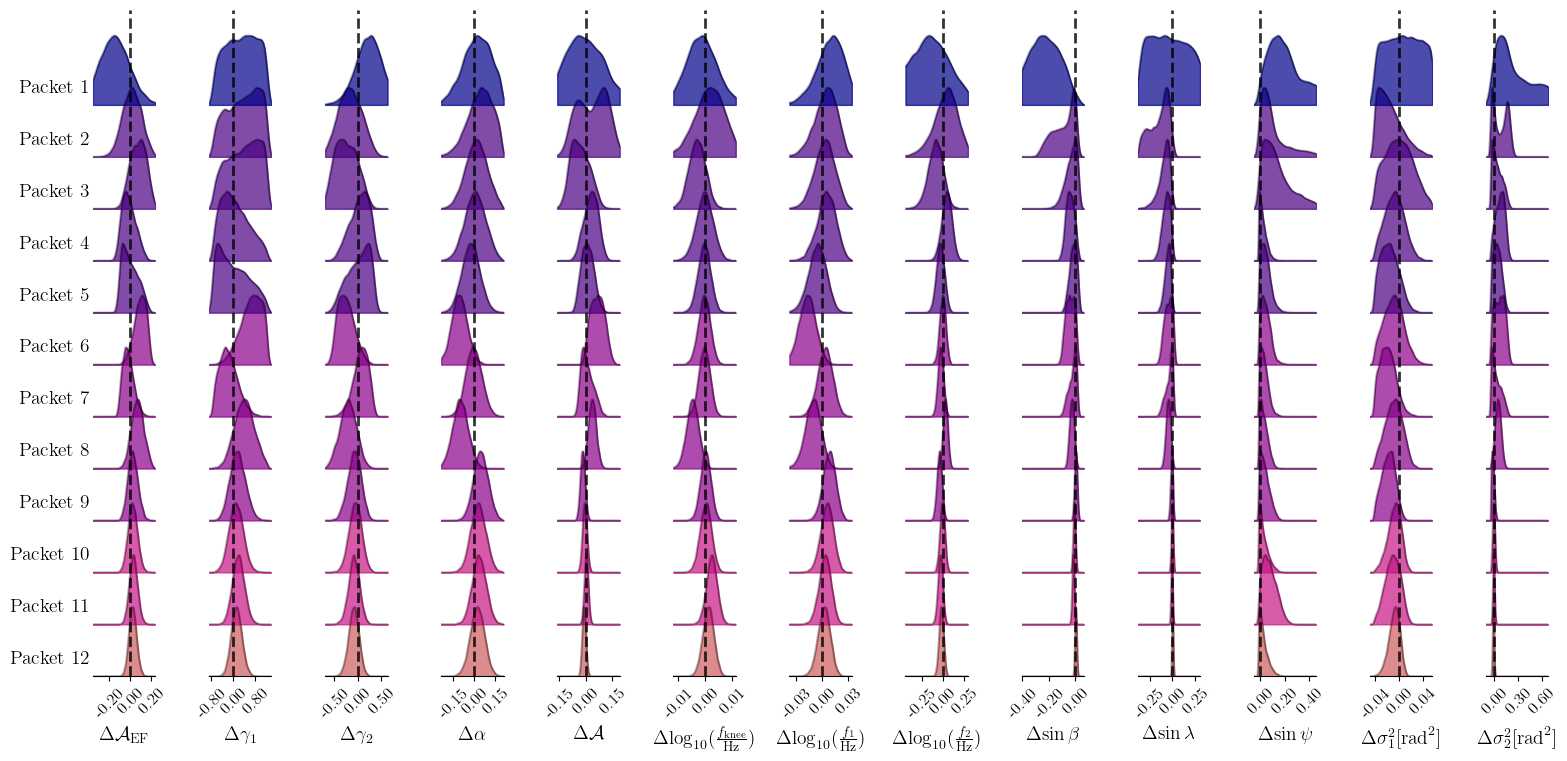

In [ ]:
mode = "cyclo"  # UPDATE THIS WITH YOUR ACTUAL MODE!
colors = colors_tot[:12][::-1]
# Run complete analysis with size management
all_samples, parameter_names, all_true_values, fig = run_complete_analysis(
    mode=mode,
    n_packs=24,
    max_packs_per_plot=24,
    pack_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
)

kwargs = dict(fontsize=14)
fig.axes[0].set_xlabel(r"$\Delta{\mathcal A}_{\rm EF}$", **kwargs)
fig.axes[1].set_xlabel(r"$\Delta{\gamma_1}$", **kwargs)
fig.axes[2].set_xlabel(r"$\Delta{\gamma_2}$", **kwargs)
fig.axes[3].set_xlabel(r"$\Delta\alpha$", **kwargs)
fig.axes[4].set_xlabel(r"$\Delta{\mathcal A}$", **kwargs)
fig.axes[5].set_xlabel(r"$\Delta{\log_{10} (\frac{f_{\rm knee}}{{\rm Hz}}})$", **kwargs)
fig.axes[6].set_xlabel(r"$\Delta{\log_{10} (\frac{f_{\rm 1}}{{\rm Hz}}})$", **kwargs)
fig.axes[7].set_xlabel(r"$\Delta{\log_{10} (\frac{f_{\rm 2}}{{\rm Hz}}})$", **kwargs)
fig.axes[8].set_xlabel(r"$\Delta{\sin \beta}$", **kwargs)
fig.axes[9].set_xlabel(r"$\Delta{\sin \lambda}$", **kwargs)
fig.axes[10].set_xlabel(r"$\Delta{\sin \psi}$", **kwargs)
fig.axes[11].set_xlabel(r"$\Delta{\sigma_1^2} [{\rm rad}^2]$ ", **kwargs)
fig.axes[12].set_xlabel(r"$\Delta{\sigma_2^2} [{\rm rad}^2]$ ", **kwargs)
# Align all x labels vertically
fig.align_xlabels(axs=[ax for ax in fig.axes])
fig.savefig("../plots/FigureA3top.pdf", dpi=300, bbox_inches="tight")


Starting analysis for mode: cyclo
Loading data...
../data/first_year_egf/pack_13/nessai/Gamma/cyclo/pec_pack13_cyclo.yaml
../data/first_year_egf/pack_14/nessai/Gamma/cyclo/pec_pack14_cyclo.yaml
../data/first_year_egf/pack_15/nessai/Gamma/cyclo/pec_pack15_cyclo.yaml
../data/first_year_egf/pack_16/nessai/Gamma/cyclo/pec_pack16_cyclo.yaml
../data/first_year_egf/pack_17/nessai/Gamma/cyclo/pec_pack17_cyclo.yaml
../data/first_year_egf/pack_18/nessai/Gamma/cyclo/pec_pack18_cyclo.yaml
../data/first_year_egf/pack_19/nessai/Gamma/cyclo/pec_pack19_cyclo.yaml
../data/first_year_egf/pack_20/nessai/Gamma/cyclo/pec_pack20_cyclo.yaml
../data/first_year_egf/pack_21/nessai/Gamma/cyclo/pec_pack21_cyclo.yaml
../data/first_year_egf/pack_22/nessai/Gamma/cyclo/pec_pack22_cyclo.yaml
../data/first_year_egf/pack_23/nessai/Gamma/cyclo/pec_pack23_cyclo.yaml
../data/first_year_egf/pack_24/nessai/Gamma/cyclo/pec_pack24_cyclo.yaml
Successfully loaded 12 packs with 15 parameters

Creating combined ridgeline plot...


/tmp/ipykernel_1194139/2266907832.py:356: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1194139/2266907832.py:356: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1194139/2266907832.py:356: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1194139/2266907832.py:356: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1194139/2266907832.py:356: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1194139/2266907832.py:356

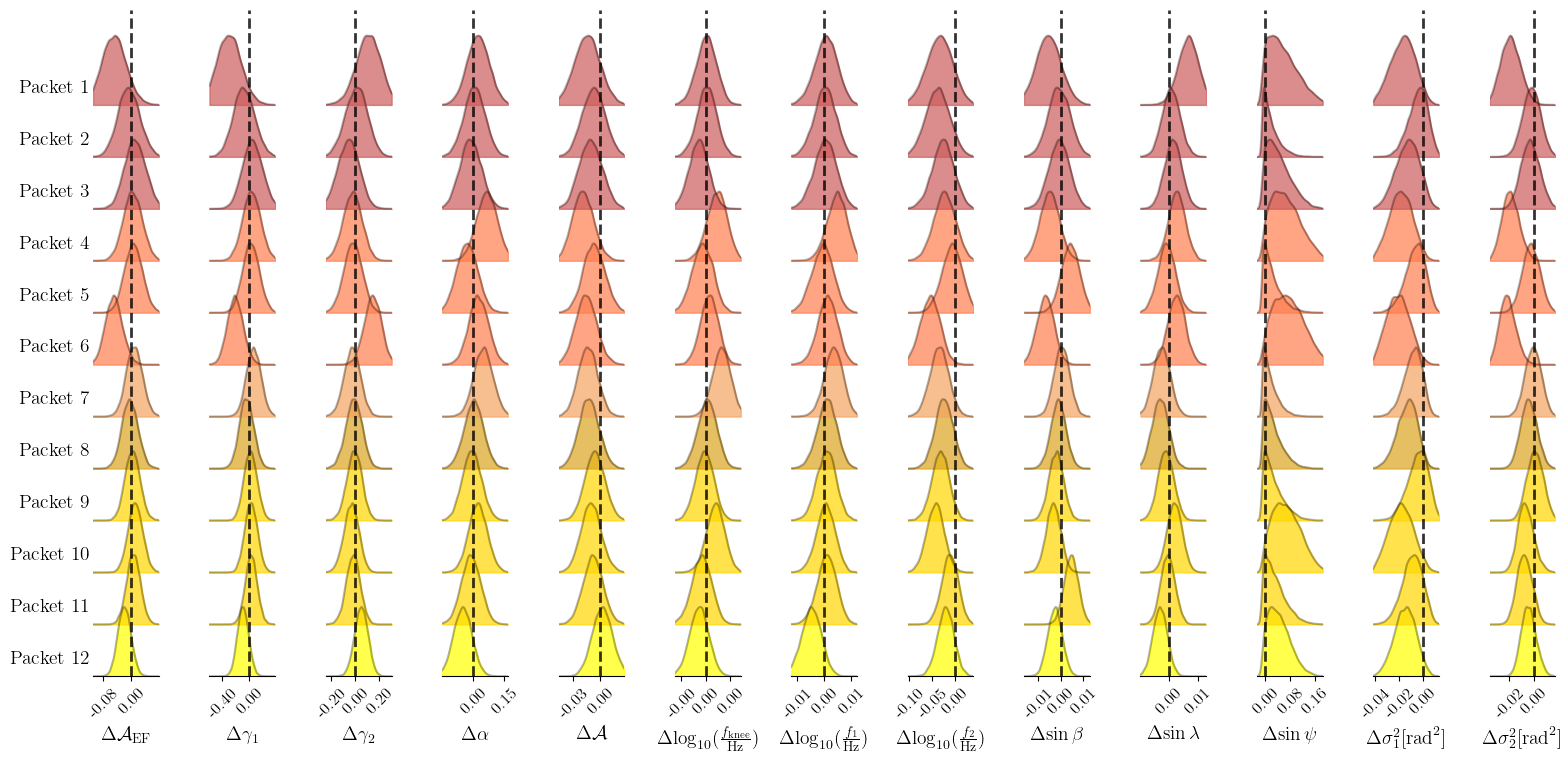

In [ ]:
mode = "cyclo"  # UPDATE THIS WITH YOUR ACTUAL MODE!
colors = colors_tot[12:][::-1]
# Run complete analysis with size management
all_samples, parameter_names, all_true_values, fig = run_complete_analysis(
    mode=mode,
    n_packs=24,
    max_packs_per_plot=24,
    pack_indices=[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
)

kwargs = dict(fontsize=14)
fig.axes[0].set_xlabel(r"$\Delta{\mathcal A}_{\rm EF}$", **kwargs)
fig.axes[1].set_xlabel(r"$\Delta{\gamma_1}$", **kwargs)
fig.axes[2].set_xlabel(r"$\Delta{\gamma_2}$", **kwargs)
fig.axes[3].set_xlabel(r"$\Delta\alpha$", **kwargs)
fig.axes[4].set_xlabel(r"$\Delta{\mathcal A}$", **kwargs)
fig.axes[5].set_xlabel(r"$\Delta{\log_{10} (\frac{f_{\rm knee}}{{\rm Hz}}})$", **kwargs)
fig.axes[6].set_xlabel(r"$\Delta{\log_{10} (\frac{f_{\rm 1}}{{\rm Hz}}})$", **kwargs)
fig.axes[7].set_xlabel(r"$\Delta{\log_{10} (\frac{f_{\rm 2}}{{\rm Hz}}})$", **kwargs)
fig.axes[8].set_xlabel(r"$\Delta{\sin \beta}$", **kwargs)
fig.axes[9].set_xlabel(r"$\Delta{\sin \lambda}$", **kwargs)
fig.axes[10].set_xlabel(r"$\Delta{\sin \psi}$", **kwargs)
fig.axes[11].set_xlabel(r"$\Delta{\sigma_1^2} [{\rm rad}^2]$ ", **kwargs)
fig.axes[12].set_xlabel(r"$\Delta{\sigma_2^2} [{\rm rad}^2]$ ", **kwargs)
# Align all x labels vertically
fig.align_xlabels(axs=[ax for ax in fig.axes])
fig.savefig("../plots/FigureA3bottom.pdf", dpi=300, bbox_inches="tight")
